In [19]:
import csv
import json
from pprint import pprint
import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

In [20]:
# In Jupyter notebook
import os
os.environ['PROJ_LIB'] = '/anaconda3/envs/greenlytics-datahub/share/proj'
from mpl_toolkits.basemap import Basemap

In [2]:
# In Colab notebook
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap

/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found
     |██▊                             | 11.4MB 6.4MB/s eta 0:00:19

KeyError: 'PROJ_LIB'

### Svenska kraftnät Nätområden

In [21]:
# source: https://www.natomraden.se/
# https://www.arcgis.com/apps/webappviewer/index.html?id=f5fa81e661c14d059da4596138c6dd15

files = ['./SE1.json', './SE2.json', './SE3.json','./SE4.json']
areas = []
for fname in files:
    with open(fname, mode='r') as f:
        areas += json.load(f)

data = [{'id': a['properties']['id'], 
      'name': a['properties']['namn'], 
      'company': a['properties']['bolag'], 
      'center_lat': a['properties']['center'][0],
      'center_lon': a['properties']['center'][1],
      'area': a['properties']['snitt'],
      'polygon': a['geometry']['coordinates'][0]} for a in areas]
df_areas = pd.DataFrame(data).set_index("id")
df_areas.to_excel("./all_areas.xlsx")
#df_areas.to_csv("./all_areas.csv")

In [4]:
#load data with cloab
raw_link = 'https://raw.githubusercontent.com/rebaseenergy/svk-data/main/all_areas.csv'
df_areas = pd.read_csv(raw_link, index_col=0)
df_areas.head()

,area,center_lat,center_lon,company,name,polygon
id,,,,,,
AJB,1,66.157699,17.858282,Vattenfall Eldistribution AB,Arvidsjaurbygden,"[[20.23361939321, 65.662917068984], [20.217048..."
BDN,1,66.059860,21.279649,Bodens Energi Nät AB,Boden,"[[21.939938351992, 66.332329969747], [21.87916..."
JUJ,1,67.785701,21.014726,Jukkasjärvi Sockens Belysningsf,Jukkasjärvi,"[[21.313742720138, 67.945159478693], [21.31135..."
KAB,1,65.973472,23.252347,Vattenfall Eldistribution AB,Kalixbygden,"[[23.567971051618, 66.285317994081], [23.60838..."
KLK,1,67.850554,20.193530,LKAB Nät AB,Kiruna LKAB,"[[[20.203713997003, 67.866671566003], [20.2058..."


### Svenska kraftnät Mimer

The Swedish TSO SVK is publishing data about consumption for different grid regions on the website [Mimer](https://mimer.svk.se/ConsumptionProfile/ConsumptionProfileIndex). The electricty demand data available is:

* Planerad (planned) [kWh/h]
* Avräknad (actual) [kWh/h]

However, the demand data (forecasted) wind power is only availabe until 2017-09-25 23:00 for some reason. The time stamps given at Mimer is given for the start of the considered interval, meaning 10:00 refers to the interval 10:00-11:00. Furthermore, it is given in Swedish normal time, meaning no correction of daylight saving time. Meaning to convert to UTC we need to remove one hour. "

In [59]:
def download_mimer_data(date_start, date_end, areas):
    dfs = []
    url_base = 'https://mimer.svk.se/'
    for area in areas: 
        url_target = 'ConsumptionProfile/DownloadText?groupByType=0&' + \
                     'PeriodFrom='+date_start.split('-')[1]+'%2F'+date_start.split('-')[2]+'%2F'+date_start.split('-')[0]+'%2000%3A00%3A00&' + \
                     'PeriodTo='+date_end.split('-')[1]+'%2F'+date_end.split('-')[2]+'%2F'+date_end.split('-')[0]+'%2000%3A00%3A00&' + \
                     'networkAreaIdString='+area
        
        url = url_base+url_target
        r = requests.get(url)
        decoded_content = r.content.decode('utf-8')
        csv_file = csv.reader(decoded_content.splitlines(), delimiter=';')
        rows = list(csv_file)
        rows = rows[1:-1] # Remove first and last line

        date, data = [], []
        for row in rows: 
            date.append(row[0])
            data.append(-float(row[1].replace(',', '.')))

        df = pd.DataFrame(data=data, index=date, columns=[area])
        df.index = pd.to_datetime(df.index)-datetime.timedelta(hours=1)
        df.index = df.index.tz_localize('UTC')
        dfs.append(df)

    df_SE = pd.concat(dfs, axis=1, join='outer')
    
    return df_SE

In [60]:
date_start = '2019-10-01'
date_end = '2020-11-10'
areas = ['AVE']
df_SE = download_mimer_data(date_start, date_end, areas)

UnicodeEncodeError: 'ascii' codec can't encode character u'\ufeff' in position 0: ordinal not in range(128)

In [61]:
df_SE.plot()

NameError: name 'df_SE' is not defined

### Energimarknadsinspektionen

In [62]:
url = 'https://www.ei.se/Documents/Publikationer/arsrapporter/el/sammanstsllningar_over_elnatsforetagens_tariffer/Storre_sakringskunder.xlsx'
url = 'https://www.ei.se/Documents/Publikationer/arsrapporter/el/sammanstsllningar_over_elnatsforetagens_tariffer/Effektkunder.xlsx'
df_ei = pd.read_excel(url, sheet_name='100kW, 350 MWh', header=6, index_col=1)

In [63]:
df_ei.loc['Ellevio AB','Unnamed: 5'].mean()

282.0

### Plot the data

In [24]:
def create_map(lon_0, lat_0, earth_radius):
    m = Basemap(llcrnrlon=5.0,
                llcrnrlat=54.0,
                urcrnrlon=30.0,
                urcrnrlat=70.0,
                projection='lcc',
                resolution='i',
                rsphere=earth_radius,
                lat_0=lat_0, 
                lon_0=lon_0)
    
    return m

lon_0 = 15.0
lat_0 = 63.0
earth_radius = 6371000.0
m = create_map(lon_0, lat_0, earth_radius)

In [56]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=0, vmax=1000)

def depth(l):
    if isinstance(l, list):
        return 1 + max(depth(item) for item in l)
    else:
        return 0

def create_collection(df):
    patches = []
    for area in df.index:
        data_list = df.loc[area, 'polygon']
        d = depth(data_list)
        if d == 2:
            polygon = np.array(data_list)
        else:
            polygon = np.array(data_list[0])
        
        x, y = m(polygon[:,0], polygon[:,1])
        xy = zip(x,y)
        
        company = df.loc[area,'company']
        if company in list(df_ei.index):
            value = df_ei.loc[company,'Unnamed: 5'].mean()
            c = cmap(norm(value))
            alpha = 1.0
        else: 
            c = nodata_color = "orange"
            alpha = 0.0
            
        patch = Polygon(xy, color=c, alpha=alpha)
        patches.append(patch)
        
    collection = PatchCollection(patches, match_original=True)
    
    return collection

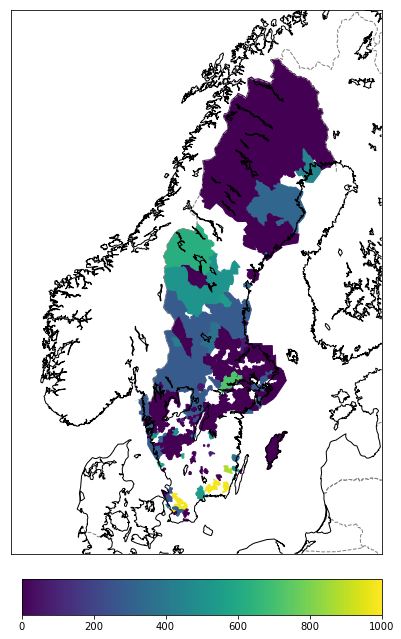

In [64]:
from matplotlib.colorbar import ColorbarBase

fig = plt.figure(figsize=(10,10))
m = create_map(lon_0, lat_0, earth_radius)
m.drawcountries(linewidth=1, linestyle='dashed', color='gray')
m.drawcoastlines()
collection = create_collection(df_areas)
plt.gca().add_collection(collection)
cax = fig.add_axes([0.27, 0.04, 0.5, 0.05]) # posititon
cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')